# The Urban Air Pollution Challenge

In this notebook we use machine learning to tackle the [Zindi Urban Air Pollution Challenge](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge):

<blockquote> 
The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. 

```PM2.5``` refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. ```PM2.5``` is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

The data comes from three main sources:

- Ground-based air quality sensors. These measure the target variable (PM2.5 particle concentration). In addition to the target column (which is the daily mean concentration) there are also columns for minimum and maximum readings on that day, the variance of the readings and the total number (count) of sensor readings used to compute the target value. This data is only provided for the train set - you must predict the target variable for the test set.

- The Global Forecast System (GFS) for weather data. Humidity, temperature and wind speed, which can be used as inputs for your model.

- The Sentinel 5P satellite. This satellite monitors various pollutants in the atmosphere. For each pollutant, we queried the offline Level 3 (L3) datasets available in Google Earth Engine (you can read more about the individual products here: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p). For a given pollutant, for example NO2, we provide all data from the Sentinel 5P dataset for that pollutant. This includes the key measurements like NO2_column_number_density (a measure of NO2 concentration) as well as metadata like the satellite altitude. We recommend that you focus on the key measurements, either the column_number_density or the tropospheric_X_column_number_density (which measures density closer to Earth’s surface).

Unfortunately, this data is not 100% complete. Some locations have no sensor readings for a particular day, and so those rows have been excluded. There are also gaps in the input data, particularly the satellite data for CH4.

</blockquote>

# Set up 
Here, we load the required packages and methods for the analyses we tried out. We also set some plotting and warning defaults, as well as a random seed for reproducibility. 

In [20]:
# Import packages and methods
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer #to be able to load the IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats

# Set defaults
sns.set_style('white')
sns.set_palette('magma')
warnings.filterwarnings('ignore')

# Air quality colors
target_cat_colors = ['#64a03c', '#eac51c', '#d67900', '#a90738', '#4f051e']

# Set random seed
RSEED = 42

# Load training data
The data can be downloaded from the ```data``` tab on [Zindi](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge). If not done so already, move the files to ```ds-airpollution\data```. 

In [6]:
df = pd.read_csv('data/Train.csv')

In [ ]:
# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create integer column for week vs. weekend (assuming traffic and industry would be much less on weekends)
df["IsWeek"] = (df["Date"].dt.weekday < 5).astype(int)

In [13]:
# Create PM2.5 air quality categories based on https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air
bins = [0, 12.5, 25, 50, 150, np.inf]
health_cat = ['good', 'fair','poor','very poor','extremely poor']
df['target_cat'] = pd.cut(df['target'], bins, labels = health_cat)

# Exploratory Data Analysis (EDA)
We start with ins and summarizing the training data. 

In [ ]:
#Check column names
df.head()

In [ ]:
#Check size of the data frame
df.shape

In [ ]:
#Check type of features
df.dtypes

# Missing data

In [ ]:
#Check number of missing values
df.isna().sum().sort_values(ascending=False)

Given the high number of missing data for some features, we ran a more detailed analysis of missing values to look for potential patterns.

In [ ]:
msno.matrix(df, fontsize=10,labels=True)

From the missingno matrix figure, it is clear that there is only missing data for the satellite data (with prefix ```L3```), not for the target or close-to-the-ground measurements. The amount of missing satellite data is  related to the type of pollutant, with only very sparse methane (```CHO4```) data.

In [ ]:
# plot percentage of missing instances with labels
# from: https://stackoverflow.com/questions/69537383/how-to-plot-count-of-null-values-for-each-column-in-pandas-dataframe
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

Looking at the percentages of missing data, we are missing over 80% data for methane (```CH4```). We will remove these columns from the data frame. 

In [14]:
# create a copy for cleaned data
df_clean = df.copy()

In [15]:
# drop CH4 columns
cols_ch4 = [col for col in df.columns if 'CH4' in col]
df_clean.drop(columns=cols_ch4, axis=1, inplace=True)

We also miss up to 25% for formaldehyde (```HCHO```) and sulferdioxide (```SO2```) and up to 20% for carbonmonoxide (```CO```), most nitrogen oxide measurements (```NO2```), cloud (```CLOUD```), ozone (```O3```), and aerosols (```AER```). Given the size of the dataset, we keep these features and impute missing data. 

# Inspect features

Let's first create two plotting functions that can be run for each pollutant or category of features from the satellite data separately. 

In [ ]:
def pol_pairplot(pol_name, data, colors):
    # This function creates a pair plot for all features belonging to 
    # one of the satellite pollutants in the input data frame, and 
    # color-codes the data points by the PM2.5 quality category.
    col_names = [col for col in data.columns if pol_name in col]
    col_names_target = col_names + ['target_cat']
    p = sns.pairplot(data = data[col_names_target], hue="target_cat", palette = colors, corner = True)
    plt.show()

def pol_confmat(pol_name, data):
    # This function plots a correlation matrix for all features belonging to 
    # one of the satellite pollutants in the input data frame.
    col_names = [col for col in data.columns if pol_name in col]
    corr = df[col_names].corr()
    matrix = np.triu(corr)
    p = sns.heatmap(corr, annot=True, mask=matrix)
    plt.show()

In [ ]:
# Create pair plots for all features belonging to a single pollutant (for a list, see above),
# color-coded by the air quality category. 

# Plot per feature: NO2, SO2, O3, CO, HCHO, AER, CLOUD
#pol_pairplot('O3', df_clean, target_cat_colors)

# Plot for each feature
sat_features = ["NO2", "SO2", "O3", "CO", "HCHO", "AER", "CLOUD"] 
for feature in sat_features:
    pol_pairplot(feature, df_clean, target_cat_colors)

Based on the pair plots for each pollutant, we identified features that likely contain a bunch of outlying zero values. For these columns, we exclude the zeros to later impute them together with missing values.

An alternative that we may want to explore at a later stage could be that these zero values stem from measurement error of the satellite, spanning multiple pollutants. Instances with unrealistic zeros spanning multiple pollutants may have to be removed altogether. 

In [ ]:
# For now, we removes the zero values that we have identified as outliers from the identified columns
# These will be imputed when training out model
variables_list_0_as_outlier = [
    "L3_NO2_NO2_column_number_density",
    "L3_NO2_NO2_slant_column_number_density",
    "L3_NO2_sensor_altitude",
    "L3_NO2_tropopause_pressure",
    "L3_NO2_solar_zenith_angle",
    "L3_SO2_SO2_column_number_density",
    "L3_SO2_SO2_column_number_density_amf",
    "L3_SO2_SO2_slant_column_number_density",
    "L3_SO2_solar_zenith_angle",
    "L3_O3_O3_column_number_density",
    "L3_O3_O3_effective_temperature",
    "L3_O3_solar_zenith_angle",
    "L3_CO_CO_column_number_density",
    "L3_CO_sensor_altitude",
    "L3_CO_solar_zenith_angle",
    "L3_HCHO_solar_zenith_angle",
    "L3_HCHO_tropospheric_HCHO_column_number_density_amf"
]
df_clean[variables_list_0_as_outlier].replace(0, np.nan, inplace=True)

In [ ]:
# Inspect correlations between features by pollutant
sat_features = ["NO2", "SO2", "O3", "CO", "HCHO", "AER", "CLOUD"] 
for feature in sat_features:
    pol_confmat(feature, df_clean)

From the correlation matrices we can see that there are high correlations between certain features, in particular the angles of the satellite. For now, we keep also highly correlating features in. 

# Split data for modeling
Note to self: this can be removed for the Zindi challenge, when we test the model trained on the full training data on the separate test data file!!

In [62]:
df_split = df_clean.copy()

In [63]:
y = df_split.pop("target")

In [64]:
# Split data (initially keep all features, also those that are not used in modeling)
df_X_train, df_X_test, y_train, y_test = train_test_split(df_split, y, test_size=0.2, random_state=RSEED)

In [72]:
# Create df_train and df_test for later inspection
df_train = df_X_train.join(y_train)
df_test = df_X_test.join(y_test)

In [84]:
# Drop non-numerical and superfluous target columns from the features for modeling
drop_features = ['Date', 'Place_ID', 'Place_ID X Date', 'target_min', 'target_max', 'target_variance', 'target_count', 'target_cat']
X_train = df_X_train.drop(columns=drop_features, axis=1)
X_test = df_X_test.drop(columns=drop_features, axis=1)

# Model 1: XGBoost

First, we will build our pipeline to run the XGBoost model. 

In [94]:
features = list(X_train.columns)

num_pipeline = Pipeline([
    ('imputer_num', KNNImputer()), #original: ```SimpleImputer(strategy='median')```
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, features),
])

pipe_xgbreg = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbreg', xgb.XGBRegressor())  
    #eta = 0.1, n_estimators=50,max_depth=10, colsample_bytree=0.8, gamma=5,reg_alpha=0,reg_lambda=10 
])

Then we can fit the pipeline to the train data. 

In [95]:
pipe_xgbreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   KNNImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['precipitable_water_entire_atmosphere',
                                                   'relative_humidity_2m_above_ground',
                                                   'specific_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'u_component_of_wind_10m_above_ground',
                                                   'v_component_of_win...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

Predict the target from the train data. 

In [96]:
y_pred_train = pipe_xgbreg.predict(X_train)

And evaluate its fit.

In [97]:
mae = mean_absolute_error(y_train, y_pred_train)
print(f"MAE for the train data: {mae:.2f}.")

MAE for the train data: 13.30.


# Model optimization through grid search 

Define the different parameters to try out.

In [105]:
param_xgbreg_rand = {
              'xgbreg__n_estimators': [25, 50, 100],
              'xgbreg__learning_rate': [0.05, 0.1, 0.2, 0.3], 
              'xgbreg__max_depth': [5, 7, 9],
              'xgbreg__colsample_bytree': [0.8],
              'xgbreg__gamma': [5],
              'xgbreg__reg_alpha': [0],
              'xgbreg__reg_lambda': [10]
            }

First run randomized grid search on a wide range of parameters.

In [106]:
rand_search_xbreg = RandomizedSearchCV(pipe_xgbreg, param_distributions=param_xgbreg_rand, cv=5, scoring='neg_mean_absolute_error', 
                                         verbose=1, n_jobs=-1, n_iter=10)

In [107]:
rand_search_xbreg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                KNNImputer()),
                                                                                               ('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['precipitable_water_entire_atmosphere',
                                                                                'relative_humidity_2m_above_ground',
                                                                                'specific_humidity_2m_above_ground',
                                                                                'temperature_2m_above_ground',
                                                                                'u_component_of_wind_10m...
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgbreg__colsample_bytree': [0.8],
                                        'xgbreg__gamma': [5],
                                        'xgbreg__learning_rate': [0.05, 0.1,
                                                                  0.2, 0.3],
                                        'xgbreg__max_depth': [5, 7, 9],
                                        'xgbreg__n_estimators': [25, 50, 100],
                                        'xgbreg__reg_alpha': [0],
                                        'xgbreg__reg_lambda': [10]},
                   scoring='neg_mean_absolute_error', verbose=1)

Evaluate best model.

In [136]:
print("Results from the best fitting model from random grid search")
print("===========================================================")
print("Parameters:")
print(f"xgbreg__reg_lambda = {rand_search_xbreg.best_params_['xgbreg__reg_lambda']}" )
print(f"xgbreg__reg_alpha = {rand_search_xbreg.best_params_['xgbreg__reg_alpha']}" )
print(f"xgbreg__n_estimators = {rand_search_xbreg.best_params_['xgbreg__n_estimators']}" )
print(f"xgbreg__max_depth = {rand_search_xbreg.best_params_['xgbreg__max_depth']}" )
print(f"xgbreg__learning_rate = {rand_search_xbreg.best_params_['xgbreg__learning_rate']}" )
print(f"xgbreg__gamma = {rand_search_xbreg.best_params_['xgbreg__gamma']}" )
print(f"xgbreg__colsample_bytree = {rand_search_xbreg.best_params_['xgbreg__colsample_bytree']}" )
print("===========================================================")
print(f"Cross validation MAE: {rand_search_xbreg.best_score_:.2f}")


Results from the best fitting model from random grid search
Parameters:
xgbreg__reg_lambda = 10
xgbreg__reg_alpha = 0
xgbreg__n_estimators = 100
xgbreg__max_depth = 9
xgbreg__learning_rate = 0.1
xgbreg__gamma = 5
xgbreg__colsample_bytree = 0.8
Cross validation MAE: -20.00


In [138]:
# Check the cross validation results to decide on a selected full grid search
rand_search_xbreg.cv_results_

{'mean_fit_time': array([ 193.43394699,  175.66854749,  163.83734622,  144.78019447,
         123.40213594, 1064.42194037,  693.62157593,  164.29642429,
         141.7759963 ,  124.59723182]),
 'std_fit_time': array([ 18.58734206,  34.36503654,   4.42705016,  18.20139147,
         17.65920936,  35.64663979, 471.62434019,   4.63894819,
         16.84545687,   7.5635319 ]),
 'mean_score_time': array([15.79278979, 17.58175831, 15.74381065, 17.6370502 , 16.3054482 ,
        18.98679543, 21.12143545, 14.30037999, 18.80325527, 10.98154035]),
 'std_score_time': array([2.41553181, 3.37368898, 1.70205261, 4.67149915, 3.22118357,
        4.52592667, 2.76117787, 0.85930372, 4.93755684, 0.81091223]),
 'param_xgbreg__reg_lambda': masked_array(data=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_xgbreg__reg_alpha': masked_array(data=[0, 

Inspection of the cross-validation results shows that the lowest mean MAEs (around 20) all have a ```learning rate``` of 0.1. 

Optimal ```max_depth``` was 7 or 9 (not 5) and there was no clear optimal ```n_estimators```. 

Based on this, we update our grid of hyperparameters: 
- vary ```learning rate``` closely around 0.1 in the full grid search
- lower ```max_depth``` to avoid overfitting
- lower ```n_estimators``` to reduce the computational load

In [139]:
param_xgbreg_grid = {
              'xgbreg__n_estimators': [25, 50],
              'xgbreg__learning_rate': [0.05, 0.1, 0.15], 
              'xgbreg__max_depth': [5, 7],
              'xgbreg__colsample_bytree': [0.8],
              'xgbreg__gamma': [5],
              'xgbreg__reg_alpha': [0],
              'xgbreg__reg_lambda': [10]
            }

In [ ]:
#param_xgbreg_grid = {
            #   'xgbreg__n_estimators': [50],
            #   'xgbreg__learning_rate': [0.1], 
            #   'xgbreg__max_depth': [10],
            #   'xgbreg__colsample_bytree': [0.8],
            #   'xgbreg__gamma': [5],
            #   'xgbreg__reg_alpha': [0],
            #   'xgbreg__reg_lambda': [10]
            # }

In [ ]:
grid_search_xbreg = GridSearchCV(pipe_xgbreg, param_grid=param_xgbreg_grid, cv=5, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1)

In [ ]:
grid_search_xbreg.fit(X_train, y_train)

Evaluate grid search. 

In [ ]:
grid_search_xbreg.best_params_, grid_search_xbreg.best_score_

# Run winning model on test data

In [ ]:
grid_search_xbreg.predict(X_test, y_test)

In [10]:
# best_model = grid_search_xbreg.best_estimator_
# y_test_predicted_grid = best_model.predict(X_test)
# y_train_predicted_grid = best_model.predict(X_train)

# print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_grid)))
# print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_grid)))

# Error Analyse

In [11]:
error = np.abs(y_pred_train - y_train)

In [12]:


df_erroranalyse = X_train.copy()
df_erroranalyse['y_true'] = y_train
df_erroranalyse['y_pred'] = y_pred_train
df_erroranalyse['abs_error'] = error
df_erroranalyse["rel_error"] = error/y_pred_train#df_erroranalyse["y_true"]

In [13]:
df_erroranalyse.fillna(df.median(),inplace=True)

In [14]:
top_fehler = df_erroranalyse.sort_values(by='abs_error', ascending=False).head(10)


In [17]:
best_model = grid_search_xbreg.best_estimator_
reg = best_model.named_steps['xgbreg']
importances = reg.feature_importances_
feature_names = X_train.columns

best_feature=list(feature_names[importances>0.04])
lst=['y_true','y_pred','abs_error','rel_error']
best_feature.extend(lst)

# best_feature

# sns.pairplot(data=df_erroranalyse[best_feature])


In [98]:
#Old, do we still need this? y_pred_test = pipe_xgbreg.predict(X_test)
y_pred_test = pipe_xgbreg.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse = mean_squared_error(y_train, y_pred_train)
rmse = mse ** 0.5
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
              
            
print(f"TEST: RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")
print(f"train: RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

TEST: RMSE: 30.89, MAE: 20.88, R²: 0.566
train: RMSE: 18.12, MAE: 13.30, R²: 0.850


## JULIAs Add

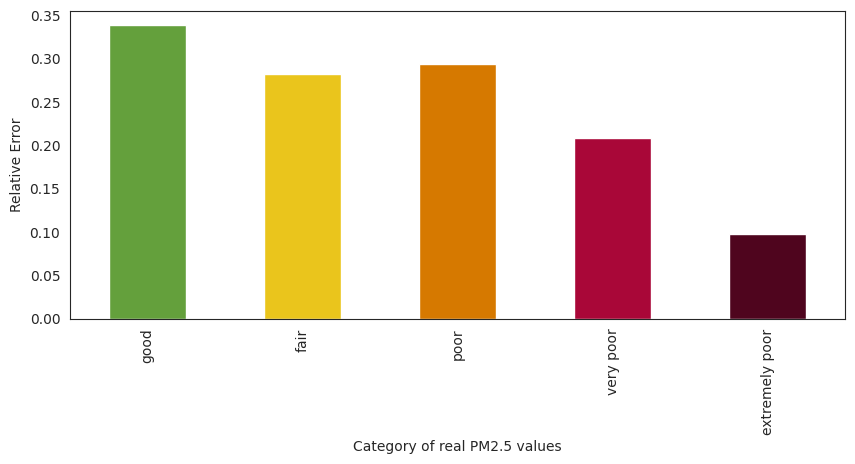

In [18]:
#from violinplot import plot_hist


colors = ['#64a03c', '#eac51c', '#d67900', '#a90738', '#4f051e']

df_for_violinplot = df_erroranalyse.copy()
bins = [0, 12.5, 25, 50, 150, np.inf]
health_cat = ['good', 'fair','poor','very poor','extremely poor']
df_for_violinplot['target_cat'] = pd.cut(df['target'], bins, labels = health_cat)
df_for_violinplot['target_cat_pred'] = pd.cut(df_for_violinplot['y_pred'], bins, labels = health_cat)

error_per_cathegory = df_for_violinplot.groupby('target_cat')['rel_error'].mean()
error_per_cathegory_pred = df_for_violinplot.groupby('target_cat_pred')['rel_error'].mean()


# error_per_cathegory.plot(kind='bar', figsize=(10, 4), color=colors)
error_per_cathegory_pred.plot(kind='bar', figsize=(10, 4), color=colors)

plt.xlabel('Category of real PM2.5 values')
plt.ylabel('Relative Error')


plt.subplots_adjust(hspace=2.4)  



# df_errors = pd.DataFrame({
#     'true cat': error_per_cathegory,
#     'predicted cat': error_per_cathegory_pred
# })
# df_errors = df_errors.sort_index()
# df_errors.plot(kind='bar', figsize=(12, 5), color=['#2EA8FF', '#2DFFCC'])



Text(0, 0.5, 'target')

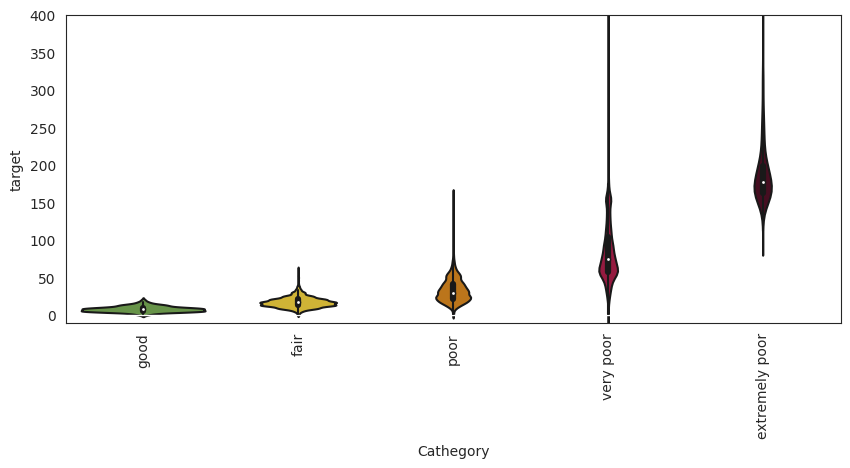

In [19]:
plt.figure(figsize=(12, 6))

sns.violinplot(x='target_cat_pred', y='y_true', data=df_for_violinplot, palette=colors)
# sns.violinplot(x='target_cat', y='y_pred', data=df_for_violinplot, palette=colors)

error_per_cathegory_pred.plot(kind='bar', figsize=(10, 4), color=colors)


plt.ylim(-10, 400)
plt.xlabel('Cathegory')
plt.ylabel('target')


Text(0, 0.5, 'True PM2.5 concentration')

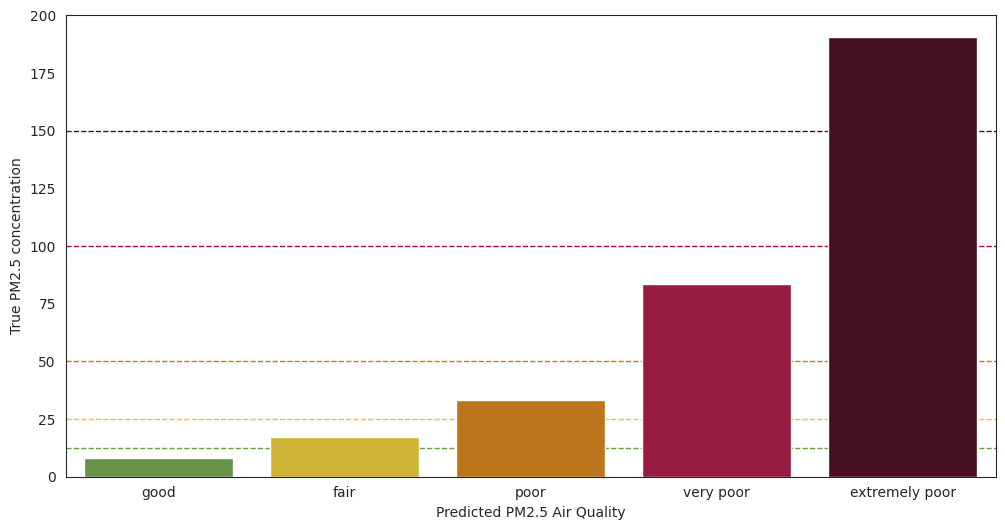

In [20]:
mean_y_true_per_category = df_for_violinplot.groupby('target_cat_pred')['y_true'].mean()


plt.figure(figsize=(12, 6))

for i, y_value in enumerate([12.5, 25, 50, 100, 150]):
    plt.axhline(y=y_value, color=colors[i], linestyle='--', linewidth=1, zorder=0)  
    
sns.barplot(x=mean_y_true_per_category.index, y=mean_y_true_per_category.values, palette=colors)

plt.xlabel('Predicted PM2.5 Air Quality')
plt.ylabel('True PM2.5 concentration')



Text(0.5, 0, 'Importance')

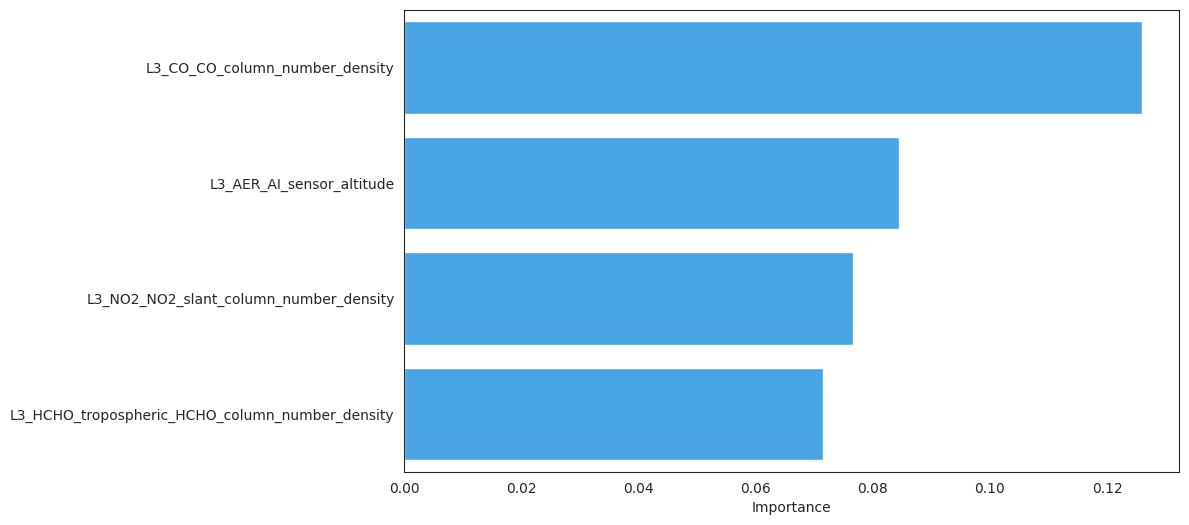

In [21]:
filtered_feature_names = feature_names[importances > 0.04]
filtered_importances = importances[importances > 0.04]

sorted_indices = np.argsort(filtered_importances)[::-1]  
sorted_feature_names = filtered_feature_names[sorted_indices]
sorted_importances = filtered_importances[sorted_indices]


plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=['#2EA8FF'])

# Titel hinzufügen
plt.xlabel("Importance")
